In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import seaborn as sns


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df = df.dropna()
df = df.drop_duplicates()

In [4]:
df

,date,time,speed,fuel_level,ignition_status
0,2023-01-01,00:00:00,102,51.245766,on
1,2023-01-01,01:00:00,92,74.168694,on
2,2023-01-01,02:00:00,14,69.884585,on
3,2023-01-01,03:00:00,106,40.255004,off
4,2023-01-01,04:00:00,71,21.802311,on
...,...,...,...,...,...
995,2023-02-11,11:00:00,119,17.837258,on
996,2023-02-11,12:00:00,58,2.907138,on
997,2023-02-11,13:00:00,127,16.688512,off
998,2023-02-11,14:00:00,113,18.131928,off


In [5]:
def detect_outliers(df):
    outliers = pd.DataFrame()
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_in_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers = pd.concat([outliers, outliers_in_column])
    return outliers.drop_duplicates()



In [6]:
def find_negative_values(df):
    negative_values = pd.DataFrame()
    for column in df.select_dtypes(include=['number']).columns:
        negative_values_in_column = df[df[column] < 0]
        negative_values = pd.concat([negative_values, negative_values_in_column])
    return negative_values.drop_duplicates()

In [7]:
outliers = detect_outliers(df)
negative_values = find_negative_values(df)

combined_results = pd.concat([outliers, negative_values]).drop_duplicates()
cleaned_df = df.drop(combined_results.index)


In [8]:
cleaned_df

,date,time,speed,fuel_level,ignition_status
0,2023-01-01,00:00:00,102,51.245766,on
1,2023-01-01,01:00:00,92,74.168694,on
2,2023-01-01,02:00:00,14,69.884585,on
3,2023-01-01,03:00:00,106,40.255004,off
4,2023-01-01,04:00:00,71,21.802311,on
...,...,...,...,...,...
995,2023-02-11,11:00:00,119,17.837258,on
996,2023-02-11,12:00:00,58,2.907138,on
997,2023-02-11,13:00:00,127,16.688512,off
998,2023-02-11,14:00:00,113,18.131928,off


In [9]:
# Описательная статистика
cleaned_df.describe()

,speed,fuel_level
count,988.000000,988.000000
mean,70.285425,49.765222
std,40.799824,28.607503
min,0.000000,0.023752
25%,35.000000,24.717238
50%,69.000000,51.109095
75%,107.000000,74.337056
max,139.000000,99.935350


In [10]:
cleaned_df['datetime'] = pd.to_datetime(cleaned_df['date'] + ' ' + cleaned_df['time'])
cleaned_df.set_index('datetime', inplace=True)

# тренд
cleaned_df['speed_trend'] = cleaned_df['speed'].rolling(window=24).mean()
cleaned_df['fuel_level_trend'] = cleaned_df['fuel_level'].rolling(window=24).mean()

last_50 = cleaned_df.tail(50)

In [11]:
def forecast_trend(trend_series, forecast_period=24):
    # Убираем NaN значения
    trend_series = trend_series.dropna()
    
    # Подготовка данных для линейной регрессии
    X = np.arange(len(trend_series)).reshape(-1, 1)
    y = trend_series.values
    
    # Создание и обучение модели линейной регрессии
    model = LinearRegression()
    model.fit(X, y)
    
    # Прогнозирование на следующие значения
    X_forecast = np.arange(len(trend_series), len(trend_series) + forecast_period).reshape(-1, 1)
    forecast = model.predict(X_forecast)
    
    return forecast

In [12]:
# Прогноз для speed_trend
speed_forecast = forecast_trend(cleaned_df['speed_trend'])

# Прогноз для fuel_level_trend
fuel_level_forecast = forecast_trend(cleaned_df['fuel_level_trend'])

# Вычисление стандартного отклонения для speed и fuel_level
speed_std_error = np.std(cleaned_df['speed'].dropna())
fuel_level_std_error = np.std(cleaned_df['fuel_level'].dropna())

# Вычисление доверительных интервалов
speed_ci = norm.ppf(0.975) * speed_std_error
fuel_level_ci = norm.ppf(0.975) * fuel_level_std_error


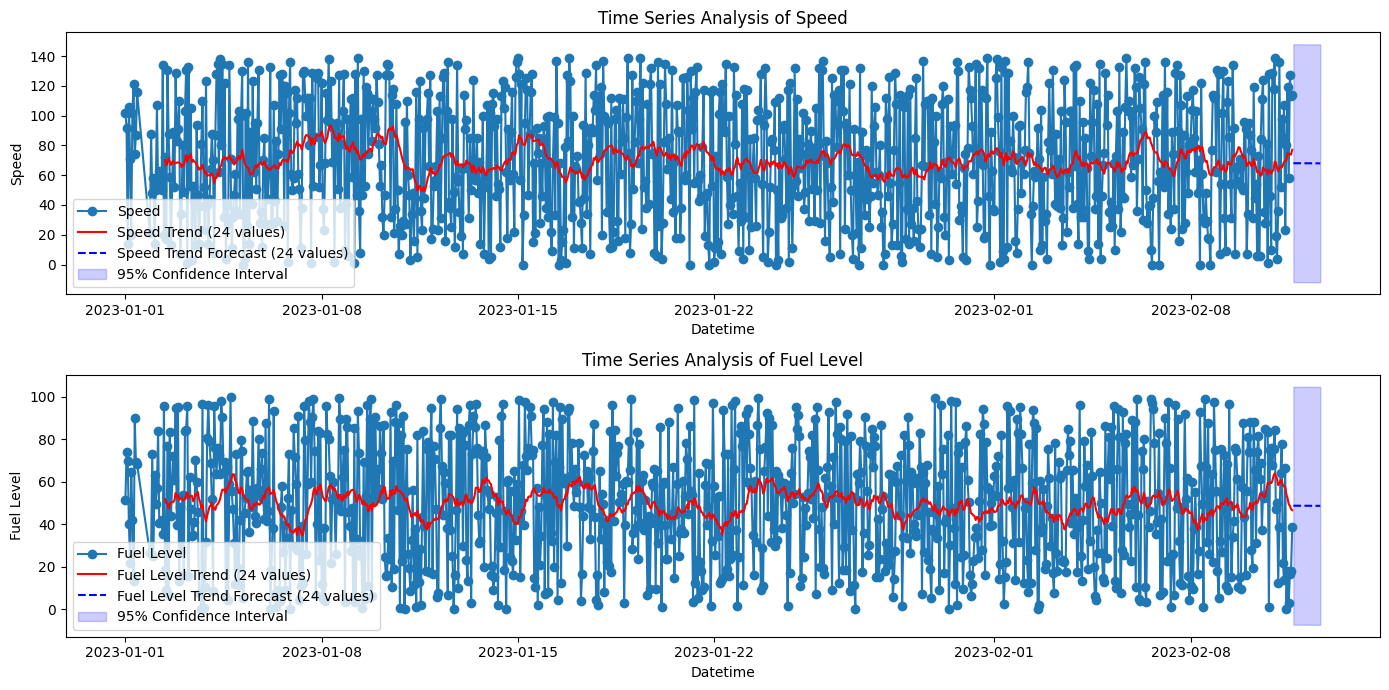

In [13]:
# Строим графики временных рядов для speed и fuel_level с трендом и прогнозом
plt.figure(figsize=(14, 7))

# График для speed
plt.subplot(2, 1, 1)
plt.plot(cleaned_df.index, cleaned_df['speed'], marker='o', linestyle='-', label='Speed')
plt.plot(cleaned_df.index, cleaned_df['speed_trend'], color='red', linestyle='-', label='Speed Trend (24 values)')
plt.plot(pd.date_range(start=cleaned_df.index[-1], periods=25, freq='h')[1:], speed_forecast, color='blue', linestyle='--', label='Speed Trend Forecast (24 values)')
plt.fill_between(pd.date_range(start=cleaned_df.index[-1], periods=25, freq='h')[1:], speed_forecast - speed_ci, speed_forecast + speed_ci, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('Time Series Analysis of Speed')
plt.xlabel('Datetime')
plt.ylabel('Speed')
plt.legend()

# График для fuel_level
plt.subplot(2, 1, 2)
plt.plot(cleaned_df.index, cleaned_df['fuel_level'], marker='o', linestyle='-', label='Fuel Level')
plt.plot(cleaned_df.index, cleaned_df['fuel_level_trend'], color='red', linestyle='-', label='Fuel Level Trend (24 values)')
plt.plot(pd.date_range(start=cleaned_df.index[-1], periods=25, freq='h')[1:], fuel_level_forecast, color='blue', linestyle='--', label='Fuel Level Trend Forecast (24 values)')
plt.fill_between(pd.date_range(start=cleaned_df.index[-1], periods=25, freq='h')[1:], fuel_level_forecast - fuel_level_ci, fuel_level_forecast + fuel_level_ci, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('Time Series Analysis of Fuel Level')
plt.xlabel('Datetime')
plt.ylabel('Fuel Level')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def correlation_report(df, col1, col2):
    # Вычисление коэффициента корреляции
    correlation_matrix = df[[col1, col2]].corr()
    correlation_value = correlation_matrix.loc[col1, col2]
    
    # Определение уровня корреляции
    if correlation_value == 1:
        level = "Полная положительная корреляция"
    elif correlation_value >= 0.7:
        level = "Сильная положительная корреляция"
    elif correlation_value >= 0.4:
        level = "Средняя положительная корреляция"
    elif correlation_value >= 0.1:
        level = "Слабая положительная корреляция"
    elif correlation_value >= -0.1:
        level = "Корреляция отсутствует"
    elif correlation_value >= -0.4:
        level = "Слабая отрицательная корреляция"
    elif correlation_value >= -0.7:
        level = "Средняя отрицательная корреляция"
    elif correlation_value >= -1:
        level = "Сильная отрицательная корреляция"
    else:
        level = "Полная отрицательная корреляция"
    
    # Вывод отчета
    print(f"Коэффициент корреляции между {col1} и {col2}: {correlation_value:.4f}")
    print(f"Уровень корреляции: {level}")

Correlation matrix:
               speed  fuel_level
speed       1.000000   -0.002016
fuel_level -0.002016    1.000000
Коэффициент корреляции между speed и fuel_level: -0.0020
Уровень корреляции: Корреляция отсутствует


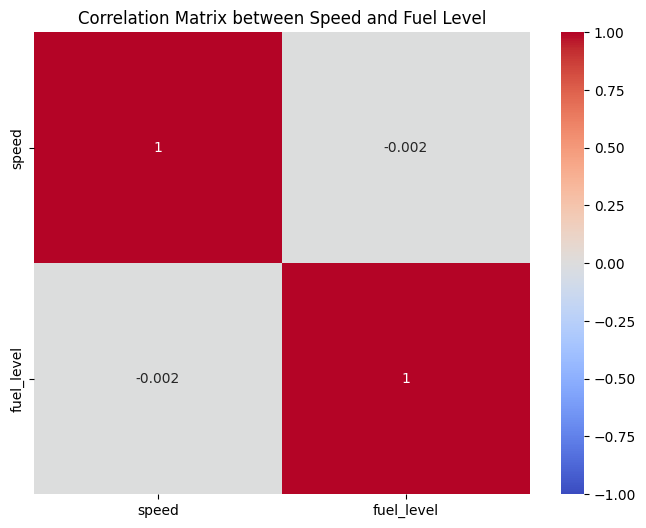

In [15]:
# Вычисление коэффициента корреляции
correlation_matrix = cleaned_df[['speed', 'fuel_level']].corr()

# Вывод коэффициента корреляции
print("Correlation matrix:")
print(correlation_matrix)
correlation_report(cleaned_df, 'speed', 'fuel_level')

# Построение тепловой карты корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Speed and Fuel Level')
plt.show()


In [16]:
# Добавление вычисленных значений в cleaned_df
cleaned_df['speed_std_error'] = speed_std_error
cleaned_df['fuel_level_std_error'] = fuel_level_std_error
cleaned_df['speed_ci'] = speed_ci
cleaned_df['fuel_level_ci'] = fuel_level_ci

In [20]:
cleaned_df.to_csv('cleaned_data.csv', index=True)

In [21]:
cleaned_df

,date,time,speed,fuel_level,ignition_status,speed_trend,fuel_level_trend,speed_std_error,fuel_level_std_error,speed_ci,fuel_level_ci
datetime,,,,,,,,,,,
2023-01-01 00:00:00,2023-01-01,00:00:00,102,51.245766,on,NaN,NaN,40.779171,28.593022,79.925707,56.041294
2023-01-01 01:00:00,2023-01-01,01:00:00,92,74.168694,on,NaN,NaN,40.779171,28.593022,79.925707,56.041294
2023-01-01 02:00:00,2023-01-01,02:00:00,14,69.884585,on,NaN,NaN,40.779171,28.593022,79.925707,56.041294
2023-01-01 03:00:00,2023-01-01,03:00:00,106,40.255004,off,NaN,NaN,40.779171,28.593022,79.925707,56.041294
2023-01-01 04:00:00,2023-01-01,04:00:00,71,21.802311,on,NaN,NaN,40.779171,28.593022,79.925707,56.041294
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-11 11:00:00,2023-02-11,11:00:00,119,17.837258,on,74.708333,52.279621,40.779171,28.593022,79.925707,56.041294
2023-02-11 12:00:00,2023-02-11,12:00:00,58,2.907138,on,73.625000,49.534568,40.779171,28.593022,79.925707,56.041294
2023-02-11 13:00:00,2023-02-11,13:00:00,127,16.688512,off,74.291667,48.666340,40.779171,28.593022,79.925707,56.041294
